In [1]:
import numpy as np
import networkx as nx
from utilities import random_expander_edges, kendall_tau, random_cycle, cycle_edges, top_10_closeness
import matplotlib.pyplot as plt
from typing import Literal

plt.style.use('_mpl-gallery')

## Is PageRank reliable?

We want to know whether PageRank can retrieve a hidden ranking. We would like this to work in perfect conditions where all comparisons are consensual and everybody gives the 'right' choice.

In [2]:
def mimic_ranking(G: nx.DiGraph, edges: list, ranking: list):
    """ Add edges to G in a way that mimics a given ranking: for any edge (a,b) in the edges list, add arrow (a,b) if b is ranked higher than a, and (b,a) otherwise"""

    ordered_edges = []
    for u, v in edges:
        if ranking.index(u) < ranking.index(v):
            ordered_edges.append((u, v))
        else:
            ordered_edges.append((v, u))
    G.add_edges_from(ordered_edges)
    return G


def apply_page_rank(G):
    """Returns the ranked list of vertices of G, according to page rank"""
    # Compute PageRank
    pr = nx.pagerank(G)
    # Sort entries with decreasing score
    sorted_entries = sorted(list(pr.items()), key=lambda e: e[1])
    # Return the sorted entries numbers
    return list(map(lambda x: x[0], sorted_entries))


def create_graph(degree, size, ranking, graph_strategy: Literal["expander", "random_regular", "recursive_pr"]):
    assert degree % 2 == 0, "The degree must be even"

    G = nx.DiGraph()
    G.add_nodes_from(range(size))

    if graph_strategy == "expander":
        edges = random_expander_edges(degree // 2, size)
        G = mimic_ranking(G, edges, ranking)
    elif graph_strategy == "random_regular":
        edges = list(nx.generators.random_graphs.random_regular_graph(degree, size).edges())
        G = mimic_ranking(G, edges, ranking)
    elif graph_strategy == "recursive_pr":
        # Start with random cycle
        edges = cycle_edges(random_cycle(size))
        G = mimic_ranking(G, edges, ranking)
        # Iteratively compute the page rank, and create new cycles of votes
        for _ in range(degree // 2 - 1):
            edges = cycle_edges(apply_page_rank(G))
            G = mimic_ranking(G, edges, ranking)
    else:
        raise NotImplementedError("This strategy does not exist")

    return G

In [3]:
def apply_ranking_strategy(degree, graph_strategy: Literal['expander', "random_regular", 'recursive_pr'], ranking_strategy: Literal["page_rank"], metric: Literal['kendall_tau', 'top_10'],data: list):
  values = [create_graph(degree, n, L, graph_strategy) for n,L  in data ]

  if ranking_strategy =="page_rank":
    final_ranking = [apply_page_rank(G) for G in values]
  else:
    raise NotImplementedError("Ranking strategy not implemented")

  if metric == "kendall_tau":
    metric = kendall_tau
  elif metric == "top_10":
    metric = top_10_closeness
  else:
    raise NotImplementedError("Not implemented metric")
  
  return [metric(rank, computed_rank) for rank, computed_rank in zip([L for _,L in data], final_ranking)]

In [4]:
# Number of samples
N = 40
# Create a list (random size, random ranking) of N tuples
data = [(n := np.random.randint(100,1500), list(np.random.permutation(n))) for _ in range(N)]

In [47]:
x = [n for n,_ in data]
random4 = apply_ranking_strategy(4, graph_strategy="random_regular", ranking_strategy="page_rank", metric="top_10",data=data)
expander4 = apply_ranking_strategy(4, graph_strategy="expander", ranking_strategy="page_rank", metric="top_10",data=data)
random8 = apply_ranking_strategy(8, graph_strategy="random_regular", ranking_strategy="page_rank", metric="top_10",data=data)
random16 = apply_ranking_strategy(16, graph_strategy="random_regular", ranking_strategy="page_rank", metric="top_10",data=data)

In [24]:
recursive4 = apply_ranking_strategy(4, graph_strategy="recursive_pr", ranking_strategy="page_rank", metric="top_10",data=data)

recursive8 = apply_ranking_strategy(8, graph_strategy="recursive_pr", ranking_strategy="page_rank", metric="top_10",data=data)

recursive16 = apply_ranking_strategy(16, graph_strategy="recursive_pr", ranking_strategy="page_rank", metric="top_10",data=data)
recursive32 = apply_ranking_strategy(16, graph_strategy="recursive_pr", ranking_strategy="page_rank", metric="top_10",data=data)
recursive64 = apply_ranking_strategy(16, graph_strategy="recursive_pr", ranking_strategy="page_rank", metric="top_10",data=data)

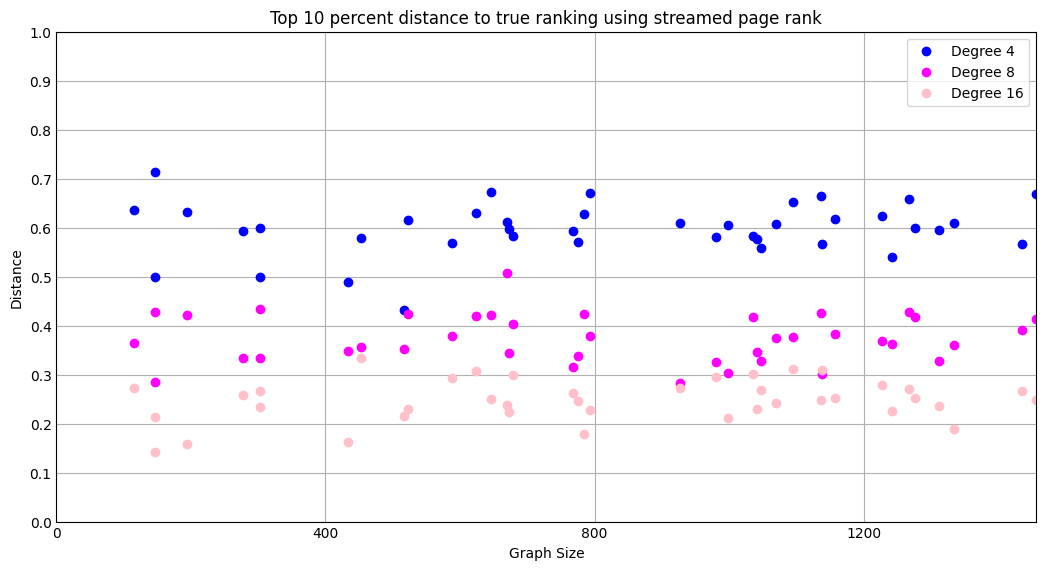

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

plot1 = ax.scatter(x, random4, c="blue", label="Degree 4")
plot2 = ax.scatter(x, random8, c="magenta", label="Degree 8")
plot3 = ax.scatter(x, random16, c="pink", label="Degree 16")
# plot4 = ax.scatter(x, recursive32, c="indigo", label="Degree 32")
# plot5 = ax.scatter(x, recursive64, c="red", label="Degree 64")


ax.legend(handles=[plot1, plot2, plot3, ])

ax.set(xlim=(0, max(x)), xticks=np.arange(0,max(x), 400 ),
       ylim=(0, 0.3), yticks=np.arange(0, 1.1, 0.1),
       xlabel="Graph Size",
       ylabel="Distance",
       title="Top 10 percent distance to true ranking using streamed page rank"
)




plt.show()